# notebooks/01_eda.py
# =============================================================================
# Retail Customer Segmentation & Revenue Drivers – EDA + RFM + Clustering
# Dataset: Sample Superstore  (Kaggle – vivek468/superstore-dataset-final)
# Author: <your-name>
# Version: 1.0  –  RFM‑only pipeline (Recency, Frequency, Monetary) + K‑Means
# =============================================================================
# Sections
#   0. Imports & Setup
#   1. Download & Load Dataset
#   2. Basic Overview & Profiling
#   3. RFM Calculation
#   4. Quantile Scoring & Segment Rules
#   5. K‑Means Clustering (features = R, F, M)
#   6. Cluster Profiling & Visuals
#   7. Save Artefacts
# =============================================================================

In [1]:
# 0. Imports & Setup --------------------------------------------------------------
import subprocess, sys, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

REQUIRED = [
    "kagglehub", "ydata_profiling", "scikit-learn", "joblib"
]
for pkg in REQUIRED:
    try:
        __import__(pkg.split("==")[0])
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pkg])

import kagglehub
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import joblib

warnings.filterwarnings("ignore")
plt.style.use("default")

# Paths ---------------------------------------------------------------------------
DATASET_REF = "vivek468/superstore-dataset-final"
DATA_DIR    = Path("data/raw");    DATA_DIR.mkdir(parents=True, exist_ok=True)
REPORT_DIR  = Path("reports");     REPORT_DIR.mkdir(parents=True, exist_ok=True)
INTERIM_DIR = Path("data/interim");INTERIM_DIR.mkdir(parents=True, exist_ok=True)


In [2]:
# 1. Download & Load Dataset -------------------------------------------------------
try:
    path = kagglehub.dataset_download(DATASET_REF, path=DATA_DIR.as_posix())
except ValueError as e:
    print("kagglehub path error – fallback to default cache", str(e))
    path = kagglehub.dataset_download(DATASET_REF)
    DATA_DIR = Path(path)  # reset base dir

csv_path = Path(path) / "Sample - Superstore.csv"
if not csv_path.exists():
    raise FileNotFoundError(f"CSV not found at {csv_path}. Check dataset contents.")

df = pd.read_csv(csv_path, encoding="windows-1252")
print("Loaded shape:", df.shape)

# Ensure datetime type
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")

print("Shape:", df.shape)
print(df.columns.tolist())
df.head()

kagglehub path error – fallback to default cache 'data/raw' is not present in the dataset files. You can access the other files of the attached dataset at '/kaggle/input/superstore-dataset-final'
Loaded shape: (9994, 21)
Shape: (9994, 21)
['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit']


Row ID        Order ID Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156 2016-11-08  11/11/2016    Second Class    CG-12520   
1       2  CA-2016-152156 2016-11-08  11/11/2016    Second Class    CG-12520   
2       3  CA-2016-138688 2016-06-12   6/16/2016    Second Class    DV-13045   
3       4  US-2015-108966 2015-10-11  10/18/2015  Standard Class    SO-20335   
4       5  US-2015-108966 2015-10-11  10/18/2015  Standard Class    SO-20335   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10001798        Furniture    Bookcases   
1       42420   South  FUR-CH-10000454        Furniture       Chairs   
2       90036    West  OFF-LA-10000240  Office Supplies       Labels   
3       33311   South  FUR-TA-10000577        Furniture       Tables   
4       33311   South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164  

[5 rows x 21 columns]

In [3]:
# 2. Basic Overview & Profiling ----------------------------------------------------
print("\n--- INFO ---"); df.info()
print("\n--- DESCRIBE ---")
print(df.describe(include="all"))

profile = ProfileReport(df, title="Superstore EDA", explorative=True)
profile.to_file(REPORT_DIR / "superstore_eda.html")
print("Profiling report saved → reports/superstore_eda.html")

HTML(open("reports/superstore_eda.html", "r", encoding="utf-8").read())


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9994 non-null   int64         
 1   Order ID       9994 non-null   object        
 2   Order Date     9994 non-null   datetime64[ns]
 3   Ship Date      9994 non-null   object        
 4   Ship Mode      9994 non-null   object        
 5   Customer ID    9994 non-null   object        
 6   Customer Name  9994 non-null   object        
 7   Segment        9994 non-null   object        
 8   Country        9994 non-null   object        
 9   City           9994 non-null   object        
 10  State          9994 non-null   object        
 11  Postal Code    9994 non-null   int64         
 12  Region         9994 non-null   object        
 13  Product ID     9994 non-null   object        
 14  Category       9994 non-null   object        
 15  Sub-Cat

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 21/21 [00:00<00:00, 24.56it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profiling report saved → reports/superstore_eda.html


In [4]:
# 3. RFM Calculation --------------------------------------------------------------
snapshot_date = df["Order Date"].max() + pd.Timedelta(days=1)
rfm = (
    df.groupby("Customer ID").agg(
        Recency   =("Order Date", lambda x: (snapshot_date - x.max()).days),
        Frequency =("Order ID", "nunique"),
        Monetary  =("Sales", "sum"),
    )
)
print("RFM head:\n", rfm.head())


RFM head:
              Recency  Frequency  Monetary
Customer ID                              
AA-10315         185          5  5563.560
AA-10375          20          9  1056.390
AA-10480         260          4  1790.512
AA-10645          56          6  5086.935
AB-10015         416          3   886.156


In [21]:
# 4. Quantile Scoring & Segment Rules --------------------------------------------
rfm["R_score"] = pd.qcut(rfm["Recency"],   5, labels=[5,4,3,2,1]).astype(int)
rfm["F_score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5]).astype(int)
rfm["M_score"] = pd.qcut(rfm["Monetary"],  5, labels=[1,2,3,4,5]).astype(int)
rfm["RFM_score"] = rfm[["R_score","F_score","M_score"]].astype(str).agg("".join, axis=1)

def segment_label(code:str) -> str:
    if code == "555":
        return "Champion"
    if code.startswith("5"):
        return "Loyal"
    if code.startswith("1"):
        return "At Risk"
    return "Need Attention"

rfm["Segment"] = rfm["RFM_score"].apply(segment_label)
print("Segment counts:\n", rfm["Segment"].value_counts())

Segment counts:
 Segment
Need Attention    472
At Risk           159
Loyal             140
Champion           22
Name: count, dtype: int64


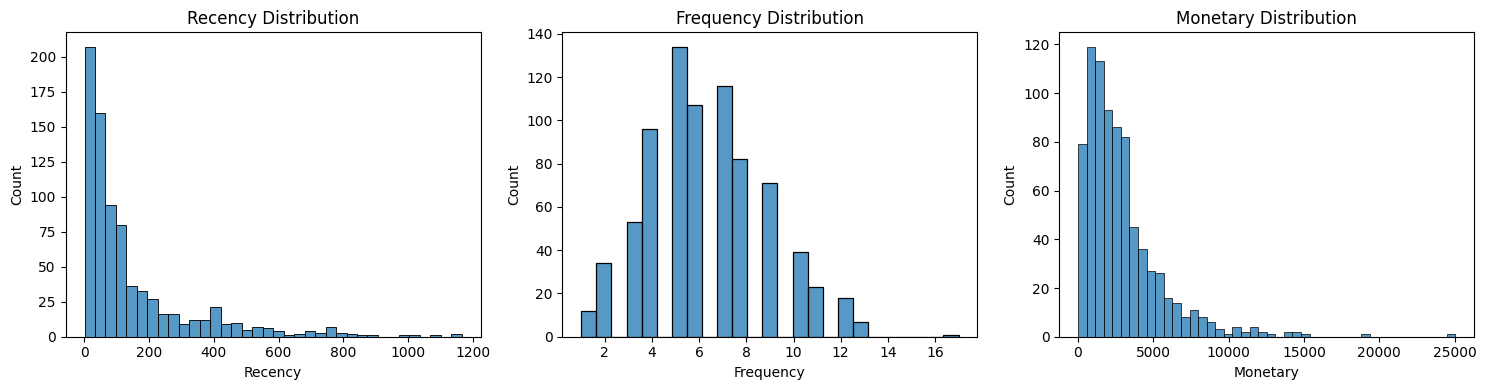

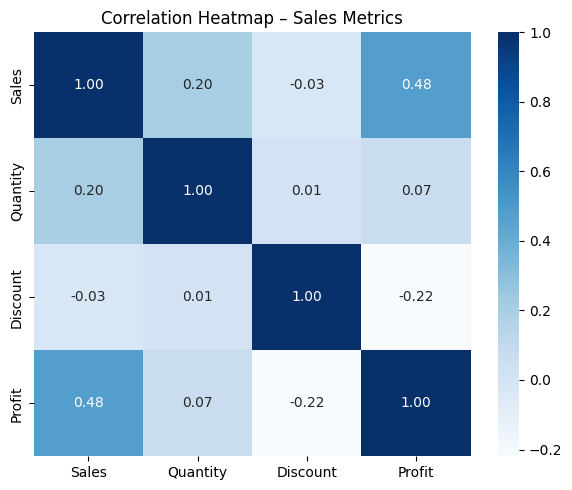

In [13]:
# Visualisations ------------------------------------------------------------------
## Histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, col in zip(axes, ["Recency", "Frequency", "Monetary"]):
    sns.histplot(rfm[col], ax=ax, kde=False)
    ax.set_title(f"{col} Distribution")
plt.tight_layout()
plt.show()

## Correlation heatmap of numeric sales metrics
num_cols = ["Sales", "Quantity", "Discount", "Profit"]
plt.figure(figsize=(6,5))
sns.heatmap(df[num_cols].corr(), annot=True, fmt=".2f", cmap="Blues")
plt.title("Correlation Heatmap – Sales Metrics")
plt.tight_layout()
plt.show()

In [17]:
# 5. K‑Means Clustering (R, F, M) --------------------------------------------------
features = ["Recency", "Frequency", "Monetary"]
X = rfm[features].copy()
X["Monetary"] = np.log1p(X["Monetary"])
X["Recency"] = np.log1p(X["Recency"])
scaler = StandardScaler(); X_scaled = scaler.fit_transform(X)

sil_scores = {}
for k in range(2, 9):
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    sil_scores[k] = sil

best_k = max(sil_scores, key=sil_scores.get)
print("Silhouette grid:", sil_scores, "→ best_k", best_k)

model = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
rfm["Cluster"] = model.fit_predict(X_scaled)
joblib.dump({"model": model, "scaler": scaler}, INTERIM_DIR / "kmeans_rfm.pkl")

Silhouette grid: {2: np.float64(0.3281354779281435), 3: np.float64(0.2716112369250618), 4: np.float64(0.2697742521788414), 5: np.float64(0.2492799344869033), 6: np.float64(0.24335904647358678), 7: np.float64(0.2513760927111438), 8: np.float64(0.23205268201404963)} → best_k 2


['data/interim/kmeans_rfm.pkl']

         n_customers  avg_recency  avg_frequency  avg_monetary  total_revenue  \
Cluster                                                                         
0                453    69.284768       7.860927   3993.638359   1.809118e+06   
1                340   252.414706       4.258824   1435.537305   4.880827e+05   

         pct_customers  pct_revenue  
Cluster                              
0            57.124842    78.753156  
1            42.875158    21.246844  


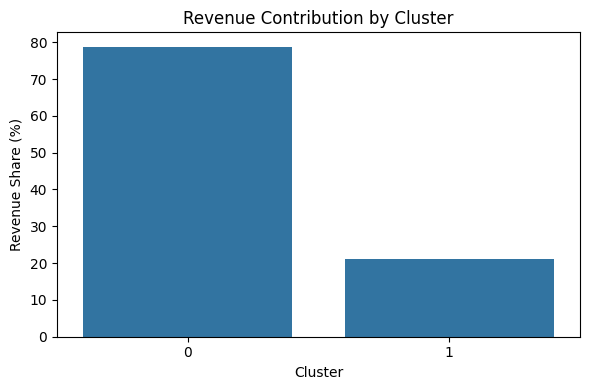

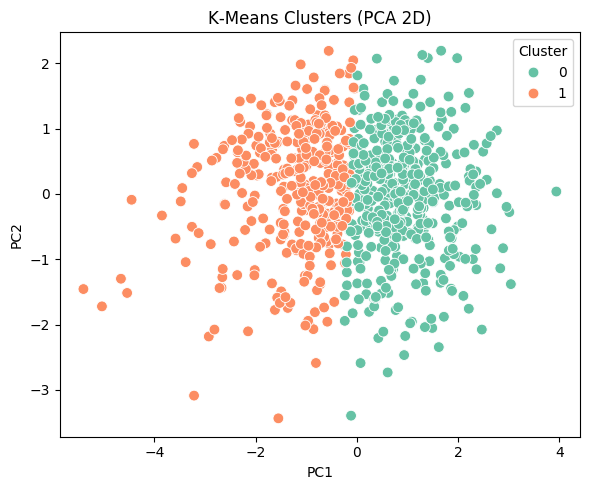

In [19]:
# 6. Cluster Profiling & Visuals ---------------------------------------------------
profile_tbl = (
    rfm.groupby("Cluster").agg(
        n_customers = ("RFM_score", "size"),
        avg_recency = ("Recency", "mean"),
        avg_frequency = ("Frequency", "mean"),
        avg_monetary = ("Monetary", "mean"),
        total_revenue = ("Monetary", "sum"),
    )
)
profile_tbl["pct_customers"] = 100*profile_tbl["n_customers"] / profile_tbl["n_customers"].sum()
profile_tbl["pct_revenue"] = 100*profile_tbl["total_revenue"] / profile_tbl["total_revenue"].sum()
print(profile_tbl)

# Bar plot revenue share
plt.figure(figsize=(6,4))
sns.barplot(x=profile_tbl.index, y="pct_revenue", data=profile_tbl)
plt.ylabel("Revenue Share (%)"); plt.xlabel("Cluster");
plt.title("Revenue Contribution by Cluster"); plt.tight_layout(); plt.show()

# 2D PCA scatter
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_scaled)
rfm["PC1"], rfm["PC2"] = coords[:,0], coords[:,1]
plt.figure(figsize=(6,5))
palette = sns.color_palette("Set2", best_k)
sns.scatterplot(data=rfm, x="PC1", y="PC2", hue="Cluster", palette=palette, s=60)
plt.title("K‑Means Clusters (PCA 2D)"); plt.tight_layout(); plt.show()


In [20]:
# 7. Save Artefacts ---------------------------------------------------------------
rfm.to_csv(INTERIM_DIR / "rfm_clustered.csv", index=True)
profile_tbl.to_csv(INTERIM_DIR / "cluster_profile.csv")
print("Artefacts saved →", INTERIM_DIR)

Artefacts saved → data/interim
